<h3 id="tocheading">Table of Contents</h3>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pickle
import random
import random
import spacy
import string
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Preprocessing

#### Load Data

In [3]:
def read_review(path):
    """reads all reviews in a category (e.g. train, pos),
    and appends them to a list as text (not tokens, yet)
    
    arg: where you keep your examples for that cagetory,
    fot example, path = data/aclImdb/train/neg/"""
    all_reviews = []
    file_list = os.listdir(path)
    for file_path in file_list:
        f = open(path+file_path)
        all_reviews.append(f.read())
    return all_reviews

In [4]:
trn_pos = read_review("data/aclImdb/train/pos/")
trn_neg = read_review("data/aclImdb/train/neg/")

test_pos = read_review("data/aclImdb/test/pos/")
test_neg = read_review("data/aclImdb/test/pos/")

#### Label & Shuffle

In [5]:
## pos = 1, neg = 0
trn_pos = [t+" 1" for t in trn_pos]
trn_neg = [t+" 0" for t in trn_neg]

test_pos = [t+" 1" for t in test_pos]
test_neg = [t+" 0" for t in test_neg]

In [6]:
data_train = trn_pos + trn_neg
test_data = test_pos + test_neg

## shuffle train data to make sure both pos and neg
## examples are represented in val data
data_train = [*np.random.permutation(data_train)]

#### Train - Val Split

In [7]:
train_split = 20000

train_data = data_train[:train_split]
val_data = data_train[train_split:]

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [8]:
## save and remove labels from the end for each review
train_data_labels = [int(x[-1]) for x in train_data]
val_data_labels = [int(x[-1]) for x in val_data]

train_data = [t[:-2] for t in train_data] ## account for the extra space that we put
val_data = [t[:-2] for t in val_data]

In [9]:
## check
print ("Train labels size is {}".format(len(train_data_labels)))
print ("Val labels size is {}".format(len(val_data_labels)))
print ("Test labels size is {}".format(len(test_data_labels)))

Train labels size is 20000
Val labels size is 5000
Test labels size is 25000


#### Tokenize & Lowercase

__Note__: Tokenizer modified to return ngrams

In [12]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

## tokenizer modified for ngrams

# lowercase and remove punctuation
def tokenize(sent,n=None):
    """n = n-gram's n"""
    tokens = tokenizer(sent)
    assert n >= 1, "n should be greater than or equal to 1"
    
    ## for unigrams
    if n == 1:
        start_unigrams = [token.text.lower() \
                          for token in tokens if (token.text not in punctuations)]
        return start_unigrams
    
    ## for n > 1 n-grams
    else:
        start_unigrams = [token.text.lower() \
                          for token in tokens if (token.text not in punctuations)]
        ## get copy to preserve original unigram list 
        start_unigrams_copy = start_unigrams.copy()
        ## start from 2
        ngram = 2
        while ngram <= n:
            ngram_tokens = [" ".join(start_unigrams_copy[x:x+ngram])\
                            for x in [*range(len(start_unigrams_copy)-ngram+1)]]
            ## union 
            start_unigrams.extend(ngram_tokens)
            ## increase n until specified ngrams
            ngram += 1
            
        return start_unigrams

def tokenize_dataset(dataset,n=None):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample,n)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [13]:
tokenize("hi, my name is Asena",n=1)

['hi', 'my', 'name', 'is', 'asena']

In [14]:
tokenize("hi, my name is Asena",n=4)

['hi',
 'my',
 'name',
 'is',
 'asena',
 'hi my',
 'my name',
 'name is',
 'is asena',
 'hi my name',
 'my name is',
 'name is asena',
 'hi my name is',
 'my name is asena']

In [15]:
## Tokenize All Datasets to contain n-grams
grams = 2
train_data_tokens, all_train_tokens = tokenize_dataset(train_data,n=grams)
val_data_tokens, _ = tokenize_dataset(val_data,n=grams)
test_data_tokens, _ = tokenize_dataset(test_data,n=grams)

#### Build Vocab

In [19]:
from collections import Counter

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,size=max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(size))
    id2token = [*vocab]
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocaab(all_train_tokens,size=max_vocab_size)

In [20]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 5270 ; token as some
Token as some; token id 5270


In [21]:
# token2id

In [22]:
## convert token to id in the dataset
## copied from lab3 notebook
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in \
                      token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


#### Pytorch Data Loader

In [23]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def imdb_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, train_data_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_data_labels)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_data_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

### Model

#### Bag of N-grams

In [24]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfNgrams(nn.Module):
    """
    BagOfNgrams classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfNgrams, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfNgrams(len(id2token), emb_dim)

In [25]:
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
## try both sgd and adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

Epoch: [1/10], Step: [101/625], Validation Acc: 75.7
Epoch: [1/10], Step: [201/625], Validation Acc: 81.14
Epoch: [1/10], Step: [301/625], Validation Acc: 83.9
Epoch: [1/10], Step: [401/625], Validation Acc: 84.8
Epoch: [1/10], Step: [501/625], Validation Acc: 85.62
Epoch: [1/10], Step: [601/625], Validation Acc: 86.6
Epoch: [2/10], Step: [101/625], Validation Acc: 86.24
Epoch: [2/10], Step: [201/625], Validation Acc: 86.12
Epoch: [2/10], Step: [301/625], Validation Acc: 85.72
Epoch: [2/10], Step: [401/625], Validation Acc: 85.38
Epoch: [2/10], Step: [501/625], Validation Acc: 85.74
Epoch: [2/10], Step: [601/625], Validation Acc: 85.34
Epoch: [3/10], Step: [101/625], Validation Acc: 85.74
Epoch: [3/10], Step: [201/625], Validation Acc: 85.56
Epoch: [3/10], Step: [301/625], Validation Acc: 85.28
Epoch: [3/10], Step: [401/625], Validation Acc: 85.32
Epoch: [3/10], Step: [501/625], Validation Acc: 85.14
Epoch: [3/10], Step: [601/625], Validation Acc: 85.26
Epoch: [4/10], Step: [101/625], 

### Hyperparameter Seach

We recommend you try different preprocessing and hyperparameters for the
model, including but not limited to:

- Tokenization schemes of the dataset.
- Model hyperparameters: Vary n for n-gram (n=1; 2; 3; 4), vocabulary size
and embedding size.
- Optimization hyperparameters: Optimizer itself (SGD vs Adam), learning
rate and whether or not you use linear annealing of learning rate (learning
rate is reduced linearly over the course of training).

In [26]:
## ngrams
## learning rate
## vocab size
## embedding size
## optimizer sgd vs adam

In [27]:
import itertools

params = [[1e-3,1e-2,1e-1,5e-1,1,10,1e2], ## learning rates
          [*range(1,5)], ## ngrams
          [10000,25000,50000,75000], ## vocab size
          [50,100,150], ## embedding size
          [100,200,300], ## max sentence length
          [16,32,64,128] ## batch size
         ]

### ADD OPTIMIZERS AT THE END
### -- THIS MEANS, WE'LL DO THE SEARCH TWICE 
### -- FOR ONCE FOR ADAM AND ONCE FOR SGD

optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate),\
             torch.optim.SGD(model.parameters(), lr=learning_rate)]

[*itertools.product(*params)][:5]

[(0.001, 1, 10000, 50, 100, 16),
 (0.001, 1, 10000, 50, 100, 32),
 (0.001, 1, 10000, 50, 100, 64),
 (0.001, 1, 10000, 50, 100, 128),
 (0.001, 1, 10000, 50, 200, 16)]

In [ ]:
## PREPARE THE NGRAM DATASETS

NGRAM_DATASETS = {}

for n in [*range(1,5)]:
#     print (n)
    grams = n
    train_data_tokens, all_train_tokens = tokenize_dataset(train_data,n=grams)
    val_data_tokens, _ = tokenize_dataset(val_data,n=grams)
    test_data_tokens, _ = tokenize_dataset(test_data,n=grams)
    
    NGRAM_DATASETS[n] = [train_data_tokens,
                        all_train_tokens,
                        val_data_tokens,
                        test_data_tokens]

In [254]:
## HYPERPARAMETER SEARCH ON VALIDATION SET

def hyperparameter_search(hyperparameter_space=None):
    """Takes as input a list of parameter search space lists."""
    ## CRITERION: ONLY CROSS ENTROPY LOSS FOR NOW
    param_space = [*itertools.product(*hyperparameter_space)]
    
    ## val loss dict
    param_losses = {}
    
    for i in param_space:
        print (i)
        
        ## will append validation losses here
        param_losses[i] = []
        
        NUM_EPOCHS = 10
        
        step = i[0] ## learning rate
        grams = i[1] ## n-grams
        vocab_size = i[2] ## vocab size
        embed_dimension = i[3] ## embedding size
        max_sentence_length = i[4] ## max sentence length of data loader
        batch_size = i[5]

        
        criterion = torch.nn.CrossEntropyLoss()

        ## tokenize training and validation data
        
        train_data_tokens = NGRAM_DATASETS[grams][0]
        all_train_tokens = NGRAM_DATASETS[grams][1]
        val_data_tokens = NGRAM_DATASETS[grams][2]
            
        train_data_tokens = NGRAM_DATASETS[grams][0]
        all_train_tokens = NGRAM_DATASETS[grams][1]
        val_data_tokens = NGRAM_DATASETS[grams][2]

        ## build vocab for the specified vocab size
        token2id, id2token = build_vocab(all_train_tokens,
                                        size=vocab_size)

        train_data_indices = token2index_dataset(train_data_tokens)
        val_data_indices = token2index_dataset(val_data_tokens)

        ## assign max sentence length and batch size from 
        ## parameter space
        MAX_SENTENCE_LENGTH = max_sentence_length
        BATCH_SIZE = batch_size

        ## load train and val data
        train_dataset = NewsGroupDataset(train_data_indices, train_data_labels)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_func,
                                                   shuffle=True)

        val_dataset = NewsGroupDataset(val_data_indices, val_data_labels)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_func,
                                                   shuffle=True)

        print ("Datasets ready.")
        ## assign embedding dimension
        ## from parameter space
        embed_dim = embed_dimension    

        ## model
        model = BagOfNgrams(len(id2token), emb_dim)
#         print ("Model ready.")
#         optimizers = [torch.optim.Adam(model.parameters(), lr=step),
#                       torch.optim.SGD(model.parameters(), lr=step)]
    
        optimizers = [torch.optim.Adam(model.parameters(), lr=step)]
        
        for optimizer in optimizers:
#             print ("Optimizer type: "+str(optimizer))
            for epoch in range(NUM_EPOCHS):
                for x, (data, lengths, labels) in enumerate(train_loader):
                    model.train()
                    data_batch, length_batch, label_batch = data, lengths, labels
                    optimizer.zero_grad()
                    outputs = model(data_batch, length_batch)
                    loss = criterion(outputs, label_batch)
                    loss.backward()
                    optimizer.step()
                    # validate every 100 iterations
                    if x > 0 and x % 100 == 0:
                        # validate
                        val_acc = test_model(val_loader, model)
                        param_losses[i].append(val_acc)
                        
    print ("Hyperparameter search done!")
    return param_losses

In [203]:
NGRAM_DATASETS[3][0][0][-1]

'out of 10'

In [255]:
## TRIGRAMS ADAM

params_trigrams_adam = [[1e-4,1e-3,1e-2,1e-1], ## learning rates
          [*range(3,4)], ## ngrams
          [100000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_trigrams_adam = hyperparameter_search(params_trigrams_adam)

(0.0001, 3, 100000, 100, 200, 32)
Datasets ready.
(0.0001, 3, 100000, 100, 200, 64)
Datasets ready.
(0.0001, 3, 100000, 200, 200, 32)
Datasets ready.
(0.0001, 3, 100000, 200, 200, 64)
Datasets ready.
(0.001, 3, 100000, 100, 200, 32)
Datasets ready.
(0.001, 3, 100000, 100, 200, 64)
Datasets ready.
(0.001, 3, 100000, 200, 200, 32)
Datasets ready.
(0.001, 3, 100000, 200, 200, 64)
Datasets ready.
(0.01, 3, 100000, 100, 200, 32)
Datasets ready.
(0.01, 3, 100000, 100, 200, 64)
Datasets ready.
(0.01, 3, 100000, 200, 200, 32)
Datasets ready.
(0.01, 3, 100000, 200, 200, 64)
Datasets ready.
(0.1, 3, 100000, 100, 200, 32)
Datasets ready.
(0.1, 3, 100000, 100, 200, 64)
Datasets ready.
(0.1, 3, 100000, 200, 200, 32)
Datasets ready.
(0.1, 3, 100000, 200, 200, 64)
Datasets ready.
Hyperparameter search done!


In [256]:
for key in [*param_val_losses_trigrams_adam.keys()]:
    param_val_losses_trigrams_adam[key] = str(param_val_losses_trigrams_adam[key])

pd.DataFrame(param_val_losses_trigrams_adam,index=\
             range(len([*param_val_losses_trigrams_adam.keys()]))).to_csv("param_val_losses_trigrams_adam.csv")
    

In [204]:
## START WITH UNIGRAMS - ADAM

params = [[1e-3,1e-2,1e-1,1,10], ## learning rates
          [*range(1,2)], ## ngrams
          [25000,50000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_unigrams = hyperparameter_search(params)

(0.001, 1, 25000, 100, 200, 32)
Datasets ready.
(0.001, 1, 25000, 100, 200, 64)
Datasets ready.
(0.001, 1, 25000, 200, 200, 32)
Datasets ready.
(0.001, 1, 25000, 200, 200, 64)
Datasets ready.
(0.001, 1, 50000, 100, 200, 32)
Datasets ready.
(0.001, 1, 50000, 100, 200, 64)
Datasets ready.
(0.001, 1, 50000, 200, 200, 32)
Datasets ready.
(0.001, 1, 50000, 200, 200, 64)
Datasets ready.
(0.01, 1, 25000, 100, 200, 32)
Datasets ready.
(0.01, 1, 25000, 100, 200, 64)
Datasets ready.
(0.01, 1, 25000, 200, 200, 32)
Datasets ready.
(0.01, 1, 25000, 200, 200, 64)
Datasets ready.
(0.01, 1, 50000, 100, 200, 32)
Datasets ready.
(0.01, 1, 50000, 100, 200, 64)
Datasets ready.
(0.01, 1, 50000, 200, 200, 32)
Datasets ready.
(0.01, 1, 50000, 200, 200, 64)
Datasets ready.
(0.1, 1, 25000, 100, 200, 32)
Datasets ready.
(0.1, 1, 25000, 100, 200, 64)
Datasets ready.
(0.1, 1, 25000, 200, 200, 32)
Datasets ready.
(0.1, 1, 25000, 200, 200, 64)
Datasets ready.
(0.1, 1, 50000, 100, 200, 32)
Datasets ready.
(0.1, 1, 5

In [220]:
for key in [*param_val_losses_unigrams.keys()]:
    param_val_losses_unigrams[key] = str(param_val_losses_unigrams[key])

In [222]:
pd.DataFrame(param_val_losses_unigrams,index=range(len([*param_val_losses_unigrams.keys()]))).to_csv("unigram_losses.csv")

In [223]:
param_val_losses_unigrams[(10, 1, 50000, 200, 200, 64)]

'[50.84, 76.32, 69.96, 79.1, 77.16, 70.48, 82.54, 79.32, 80.54, 79.34, 81.36, 80.46, 78.44, 80.6, 76.02, 77.42, 80.06, 80.78, 81.9, 83.12, 81.02, 80.62, 82.18, 74.16, 83.16, 81.44, 79.42, 81.84, 81.18, 80.88]'

In [225]:
## BIGRAMS

##RUNNING ON THE OTHER NOTEBOOK 

params_bigrams = [[1e-3,1e-2,1e-1,1,10], ## learning rates
          [2], ## ngrams
          [25000,50000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_bigrams = hyperparameter_search(hyperparameter_space=params_bigrams)

(0.001, 2, 25000, 100, 200, 32)
Datasets ready.
(0.001, 2, 25000, 100, 200, 64)
Datasets ready.
(0.001, 2, 25000, 200, 200, 32)
Datasets ready.
(0.001, 2, 25000, 200, 200, 64)
Datasets ready.
(0.001, 2, 50000, 100, 200, 32)
Datasets ready.
(0.001, 2, 50000, 100, 200, 64)
Datasets ready.
(0.001, 2, 50000, 200, 200, 32)
Datasets ready.
(0.001, 2, 50000, 200, 200, 64)
Datasets ready.
(0.01, 2, 25000, 100, 200, 32)
Datasets ready.
(0.01, 2, 25000, 100, 200, 64)
Datasets ready.
(0.01, 2, 25000, 200, 200, 32)
Datasets ready.
(0.01, 2, 25000, 200, 200, 64)
Datasets ready.
(0.01, 2, 50000, 100, 200, 32)
Datasets ready.
(0.01, 2, 50000, 100, 200, 64)
Datasets ready.
(0.01, 2, 50000, 200, 200, 32)
Datasets ready.
(0.01, 2, 50000, 200, 200, 64)
Datasets ready.
(0.1, 2, 25000, 100, 200, 32)
Datasets ready.
(0.1, 2, 25000, 100, 200, 64)
Datasets ready.
(0.1, 2, 25000, 200, 200, 32)
Datasets ready.
(0.1, 2, 25000, 200, 200, 64)
Datasets ready.
(0.1, 2, 50000, 100, 200, 32)
Datasets ready.
(0.1, 2, 5

In [226]:
for key in [*param_val_losses_bigrams.keys()]:
    param_val_losses_bigrams[key] = str(param_val_losses_bigrams[key])
    
pd.DataFrame(param_val_losses_bigrams,index=range(len([*param_val_losses_bigrams.keys()]))).to_csv("bigram_losses.csv")

In [ ]:
## FOURGRAMS

params_fourgrams = [[1e-3,1e-2,1e-1,1,10], ## learning rates
          [*range(3,4)], ## ngrams
          [25000,5000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_fourgrams = hyperparameter_search(hyperparameter_space=params_fourgrams)

In [230]:
## HYPERPARAMETER SEARCH ON VALIDATION SET

def hyperparameter_search(hyperparameter_space=None):
    """Takes as input a list of parameter search space lists."""
    ## CRITERION: ONLY CROSS ENTROPY LOSS FOR NOW
    param_space = [*itertools.product(*hyperparameter_space)]
    
    ## val loss dict
    param_losses = {}
    
    for i in param_space:
        print (i)
        
        ## will append validation losses here
        param_losses[i] = []
        
        NUM_EPOCHS = 10
        
        step = i[0] ## learning rate
        grams = i[1] ## n-grams
        vocab_size = i[2] ## vocab size
        embed_dimension = i[3] ## embedding size
        max_sentence_length = i[4] ## max sentence length of data loader
        batch_size = i[5]

        
        criterion = torch.nn.CrossEntropyLoss()

        ## tokenize training and validation data
        
        train_data_tokens = NGRAM_DATASETS[grams][0]
        all_train_tokens = NGRAM_DATASETS[grams][1]
        val_data_tokens = NGRAM_DATASETS[grams][2]
            
        train_data_tokens = NGRAM_DATASETS[grams][0]
        all_train_tokens = NGRAM_DATASETS[grams][1]
        val_data_tokens = NGRAM_DATASETS[grams][2]

        ## build vocab for the specified vocab size
        token2id, id2token = build_vocab(all_train_tokens,
                                        size=vocab_size)

        train_data_indices = token2index_dataset(train_data_tokens)
        val_data_indices = token2index_dataset(val_data_tokens)

        ## assign max sentence length and batch size from 
        ## parameter space
        MAX_SENTENCE_LENGTH = max_sentence_length
        BATCH_SIZE = batch_size

        ## load train and val data
        train_dataset = NewsGroupDataset(train_data_indices, train_data_labels)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_func,
                                                   shuffle=True)

        val_dataset = NewsGroupDataset(val_data_indices, val_data_labels)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_func,
                                                   shuffle=True)

        print ("Datasets ready.")
        ## assign embedding dimension
        ## from parameter space
        embed_dim = embed_dimension    

        ## model
        model = BagOfNgrams(len(id2token), emb_dim)
#         print ("Model ready.")
#         optimizers = [torch.optim.Adam(model.parameters(), lr=step),
#                       torch.optim.SGD(model.parameters(), lr=step)]
    
        optimizers = [torch.optim.SGD(model.parameters(), lr=step)]
        
        for optimizer in optimizers:
#             print ("Optimizer type: "+str(optimizer))
            for epoch in range(NUM_EPOCHS):
                for x, (data, lengths, labels) in enumerate(train_loader):
                    model.train()
                    data_batch, length_batch, label_batch = data, lengths, labels
                    optimizer.zero_grad()
                    outputs = model(data_batch, length_batch)
                    loss = criterion(outputs, label_batch)
                    loss.backward()
                    optimizer.step()
                    # validate every 100 iterations
                    if x > 0 and x % 100 == 0:
                        # validate
                        val_acc = test_model(val_loader, model)
                        param_losses[i].append(val_acc)
                        
    print ("Hyperparameter search done!")
    return param_losses

In [249]:
## BIGRAMS

params_bigrams = [[1e-3,1e-2,1e-1,1,10], ## learning rates
          [*range(2,3)], ## ngrams
          [25000,50000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_bigrams = hyperparameter_search(params_bigrams)

In [252]:
## TRIGRAMS SGD

params_trigrams = [[1e-4,1e-3,1e-2,1e-1], ## learning rates
          [*range(3,4)], ## ngrams
          [100000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          [32,64] ## batch size
         ]

param_val_losses_trigrams = hyperparameter_search(params_trigrams)

(0.0001, 3, 100000, 100, 200, 32)
Datasets ready.
(0.0001, 3, 100000, 100, 200, 64)
Datasets ready.
(0.0001, 3, 100000, 200, 200, 32)
Datasets ready.
(0.0001, 3, 100000, 200, 200, 64)
Datasets ready.
(0.001, 3, 100000, 100, 200, 32)
Datasets ready.
(0.001, 3, 100000, 100, 200, 64)
Datasets ready.
(0.001, 3, 100000, 200, 200, 32)
Datasets ready.
(0.001, 3, 100000, 200, 200, 64)
Datasets ready.
(0.01, 3, 100000, 100, 200, 32)
Datasets ready.
(0.01, 3, 100000, 100, 200, 64)
Datasets ready.
(0.01, 3, 100000, 200, 200, 32)
Datasets ready.
(0.01, 3, 100000, 200, 200, 64)
Datasets ready.
(0.1, 3, 100000, 100, 200, 32)
Datasets ready.
(0.1, 3, 100000, 100, 200, 64)
Datasets ready.
(0.1, 3, 100000, 200, 200, 32)
Datasets ready.
(0.1, 3, 100000, 200, 200, 64)
Datasets ready.
Hyperparameter search done!


In [253]:
for key in [*param_val_losses_trigrams.keys()]:
    param_val_losses_trigrams[key] = str(param_val_losses_trigrams[key])
    
pd.DataFrame(param_val_losses_trigrams,index=range(len([*param_val_losses_trigrams.keys()]))).to_csv("trigram_sgd_losses.csv")

### H-parameter Search Results

In [236]:
param_dict = {0:"learning_rate",
             1:"ngrams",
             2:"vocab_size",
             3:"embedding_size",
             4:"max_sentence_length",
             5:"batch_size"}

#### Accuracy Data Cleaning Function

In [243]:
def clean_df(path=None,n=None,delete_cols=None):
    """Takes as input a csv, path. Cleans and returns the
    validation accuracy dataset."""
    gram_losses = pd.DataFrame(pd.read_csv(path,header=None))
    
    ## grams
    hyperparam_sets_ = []

    for i in [*range(1,gram_losses.shape[1])]:
        hyperparams = [*gram_losses[i].iloc[:6]]
        hyperparam_sets_.append(hyperparams)

    hyperparam_sets_ = pd.Series(hyperparam_sets_).\
    apply(lambda x: [float(x[i]) for i in [*range(len(x))]])

    gram_losses = gram_losses.dropna(1)
    gram_losses = gram_losses.drop([*range(6)],0)
    gram_losses = gram_losses.T
    gram_losses["params"] = [*hyperparam_sets_]
    param_cols_ = {}

    for key in [*param_dict.keys()]:
        param_cols_[param_dict[key]] = gram_losses["params"].\
        apply(lambda x: x[key])

    param_cols_ = {}
    for key in [*param_dict.keys()]:
        param_cols_[param_dict[key]] = gram_losses["params"].\
        apply(lambda x: x[key])

    for key in [*param_cols_.keys()]:
        gram_losses[key] = param_cols_[key]

    gram_losses = gram_losses.drop("params",1)
    gram_losses["ngrams"] = [n for i in [*range(len(gram_losses))]]
    gram_losses = gram_losses.drop([*range(7,int(delete_cols))],1)

    gram_losses["val_acc"] = gram_losses[6].\
    apply(lambda x: str(x).replace("[","").\
          replace("]","").split(", "))

    gram_losses = gram_losses.drop(6,1)
    
    return gram_losses

#### Reading the Accuracy Data

In [327]:
hyperparams = pd.concat([clean_df(path="unigram_losses.csv",n=1,delete_cols=46),
                              clean_df(path="bigram_losses.csv",n=2,delete_cols=46),
                              clean_df(path="trigram_losses.csv",n=3,delete_cols=46)],0)

hyperparams["optimizer"] = ["Adam" for x in [*range(len(hyperparams))]]

sgd_uni_df = clean_df(path="unigram_SGD_losses.csv",n=1,delete_cols=46)
sgd_uni_new = clean_df(path="unigram_SGD_losses_new.csv",n=1,delete_cols=26)
sgd_bi_df = clean_df(path="bigram_sgd_losses.csv",n=2,delete_cols=46)
trigram_sgd_df = clean_df(path="trigram_sgd_losses.csv",n=3,delete_cols=22)
trigram_adam_df = clean_df(path="param_val_losses_trigrams_adam.csv",n=3,delete_cols=22)

sgd_uni_df["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_df))]]
sgd_uni_new["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_new))]]
sgd_bi_df["optimizer"] = ["SGD" for x in [*range(len(sgd_bi_df))]]
trigram_sgd_df["optimizer"] = ["SGD" for x in [*range(len(trigram_sgd_df))]]
trigram_adam_df["optimizer"] = ["Adam" for x in [*range(len(trigram_adam_df))]]

hyperparams = pd.concat([hyperparams,
                        sgd_uni_df,
                        sgd_uni_new,
                        sgd_bi_df,
                        trigram_sgd_df,
                        trigram_adam_df],0)

hyperparams["model_no"] = [*range(len(hyperparams))] 
hyperparams = hyperparams.set_index("model_no",drop=True)

print ("Total number of hyperparameter combinations included in the search is: "+ str(hyperparams.shape[0]))

Total number of hyperparameter combinations included in the search is: 252


In [328]:
## c heck
hyperparams[hyperparams["ngrams"]==3][-3:]

,learning_rate,ngrams,vocab_size,embedding_size,max_sentence_length,batch_size,val_acc,optimizer
model_no,,,,,,,,
249,0.1,3,100000.0,100.0,200.0,64.0,"[83.64, 84.54, 84.5, 84.44, 84.84, 84.84, 82.5...",Adam
250,0.1,3,100000.0,200.0,200.0,32.0,"[81.68, 84.26, 81.14, 85.48, 85.86, 81.46, 80....",Adam
251,0.1,3,100000.0,200.0,200.0,64.0,"[83.34, 83.74, 85.08, 83.8, 84.58, 84.54, 84.2...",Adam


In [329]:
max_epochs = max([*(hyperparams["val_acc"].apply(lambda x: len(x)))])
print ("The maximum number of epochs is: " + str(max_epochs))

The maximum number of epochs is: 60


In [330]:
epoch_30_index = np.where(np.array([*(hyperparams["val_acc"].apply(lambda x: len(x)))])==30)
epoch_60_index = np.where(np.array([*(hyperparams["val_acc"].apply(lambda x: len(x)))])==60)

In [331]:
hyperparams["val_acc"] = hyperparams["val_acc"].apply(lambda x: x + ["-" for i in [*range(60-len(x))]])

In [333]:
for i in range(60):
    hyperparams["epoch_"+str(i)] = hyperparams["val_acc"].apply(lambda x: x[i])

In [295]:
hyperparams = hyperparams.drop("val_acc",1)

In [296]:
hyperparams.to_csv("hyperparams_accuracy.csv")

In [482]:
param_cols = ["learning_rate",
             "ngrams",
             "vocab_size",
             "embedding_size",
             "max_sentence_length",
             "batch_size",
             "optimizer",
             "epoch_0","epoch_29","epoch_20","epoch_59"]

In [334]:
hyperparams["epoch_29"] = hyperparams["epoch_29"].apply(lambda x: float(x))

In [339]:
hyperparams["epoch_15"] = hyperparams["epoch_15"].apply(lambda x: float(x))

#### 3 Best Models for Each Batch Size

In [483]:
slow_df = hyperparams[hyperparams["batch_size"]==32]
slow_df.sort_values(by="epoch_29",ascending=False)[param_cols].head(3)

,learning_rate,ngrams,vocab_size,embedding_size,max_sentence_length,batch_size,optimizer,epoch_0,epoch_29,epoch_20,epoch_59
model_no,,,,,,,,,,,
42,0.001,2,25000.0,200.0,200.0,32.0,Adam,52.34,85.80,84.78,86.6
242,0.001,3,100000.0,200.0,200.0,32.0,Adam,50.3,85.64,84.74,86.7
46,0.001,2,50000.0,200.0,200.0,32.0,Adam,54.28,85.64,84.74,86.6


In [484]:
fast_df = hyperparams[hyperparams["batch_size"]==64]
fast_df.sort_values(by="epoch_20",ascending=False)[param_cols].head(3)

,learning_rate,ngrams,vocab_size,embedding_size,max_sentence_length,batch_size,optimizer,epoch_0,epoch_29,epoch_20,epoch_59
model_no,,,,,,,,,,,
47,0.001,2,50000.0,200.0,200.0,64.0,Adam,56.88,86.50,85.74,-
45,0.001,2,50000.0,100.0,200.0,64.0,Adam,49.46,86.44,85.68,-
43,0.001,2,25000.0,200.0,200.0,64.0,Adam,51.36,86.38,85.62,-


### Ablation Study

#### Plot Code (Same as plots.ipynb)

In [366]:
from __future__ import division
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

cutoff = np.where(np.array(sorted_names)=="turquoise")

colors = ["b","m","g","crimson","darkorange"] + sorted_names[cutoff[0][0]:]

## read data

hyperparams_plot = pd.concat([clean_df(path="unigram_losses.csv",n=1,delete_cols=46),
                              clean_df(path="bigram_losses.csv",n=2,delete_cols=46),
                              clean_df(path="trigram_losses.csv",n=3,delete_cols=46)],0)

hyperparams_plot["optimizer"] = ["Adam" for x in [*range(len(hyperparams_plot))]]

sgd_uni_df = clean_df(path="unigram_SGD_losses.csv",n=1,delete_cols=46)
sgd_uni_new = clean_df(path="unigram_SGD_losses_new.csv",n=1,delete_cols=26)
sgd_bi_df = clean_df(path="bigram_sgd_losses.csv",n=2,delete_cols=46)
trigram_sgd_df = clean_df(path="trigram_sgd_losses.csv",n=3,delete_cols=22)
trigram_adam_df = clean_df(path="param_val_losses_trigrams_adam.csv",n=3,delete_cols=22)

sgd_uni_df["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_df))]]
sgd_uni_new["optimizer"] = ["SGD" for x in [*range(len(sgd_uni_new))]]
sgd_bi_df["optimizer"] = ["SGD" for x in [*range(len(sgd_bi_df))]]
trigram_sgd_df["optimizer"] = ["SGD" for x in [*range(len(trigram_sgd_df))]]
trigram_adam_df["optimizer"] = ["Adam" for x in [*range(len(trigram_adam_df))]]

hyperparams_plot = pd.concat([hyperparams_plot,
                        sgd_uni_df,
                        sgd_uni_new,
                        sgd_bi_df,
                        trigram_sgd_df,
                        trigram_adam_df],0)

hyperparams_plot["model_no"] = [*range(len(hyperparams_plot))] 
hyperparams_plot = hyperparams_plot.set_index("model_no",drop=True)

print ("Total number of hyperparameter combinations included in the search is: "+ str(hyperparams_plot.shape[0]))

Total number of hyperparameter combinations included in the search is: 252


In [352]:
## for 60 epochs
ablation_cols = ["learning_rate",
             "ngrams",
             "vocab_size",
             "embedding_size",
             "max_sentence_length",
             "batch_size",
             "optimizer",
             "epoch_0","epoch_10","epoch_30","epoch_40","epoch_50","epoch_59"]

#### n-grams

In [364]:
ablation_params_n = [[1e-3,1e-2,1e-1,1,10], ## learning rates
          [25000,50000,100000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          ["SGD","Adam"] ##Optimizer
         ]

param_set = pd.Series([*(itertools.product(*ablation_params_n))]).unique()[1]
lr = param_set[0]
vocab = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
optimizer = param_set[4]

param_set_df = hyperparams[(hyperparams["learning_rate"]==lr)&\
                          (hyperparams["vocab_size"]==vocab)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["optimizer"]==optimizer)]

param_set_df[ablation_cols]

,learning_rate,ngrams,vocab_size,embedding_size,max_sentence_length,batch_size,optimizer,epoch_0,epoch_10,epoch_30,epoch_40,epoch_50,epoch_59
model_no,,,,,,,,,,,,,
0,0.001,1,25000.0,100.0,200.0,32.0,Adam,50.82,81.82,85.74,86.16,86.48,86.3
1,0.001,1,25000.0,100.0,200.0,64.0,Adam,54.32,82.8,-,-,-,-
40,0.001,2,25000.0,100.0,200.0,32.0,Adam,53.94,80.76,85.7,85.92,86.82,86.4
41,0.001,2,25000.0,100.0,200.0,64.0,Adam,57.24,82.36,-,-,-,-
80,0.001,3,25000.0,100.0,200.0,32.0,Adam,50.22,51.8,52.14,51.94,52.54,52.4
81,0.001,3,25000.0,100.0,200.0,64.0,Adam,49.34,50.56,-,-,-,-


Text(0.5,1,'n-gram Accuracy')

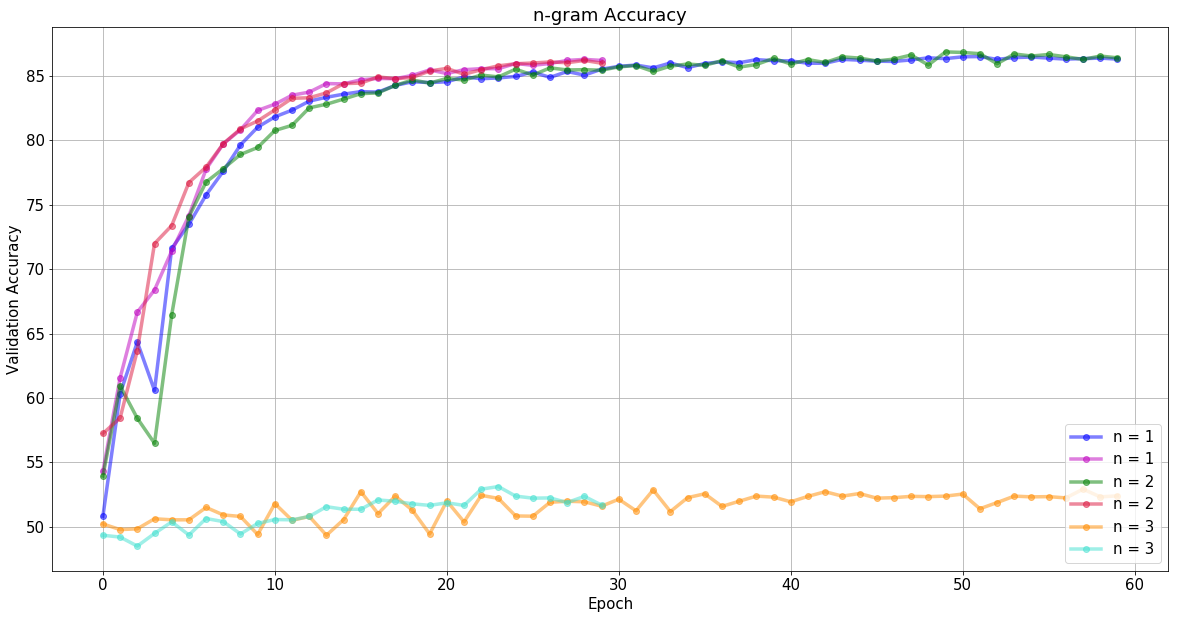

In [378]:
param_set_df_plot = hyperparams_plot[(hyperparams_plot["learning_rate"]==lr)&\
                          (hyperparams_plot["vocab_size"]==vocab)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("n = " + str(param_set_df_plot["ngrams"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("n-gram Accuracy")

Text(0.5,1,'n-gram Accuracy')

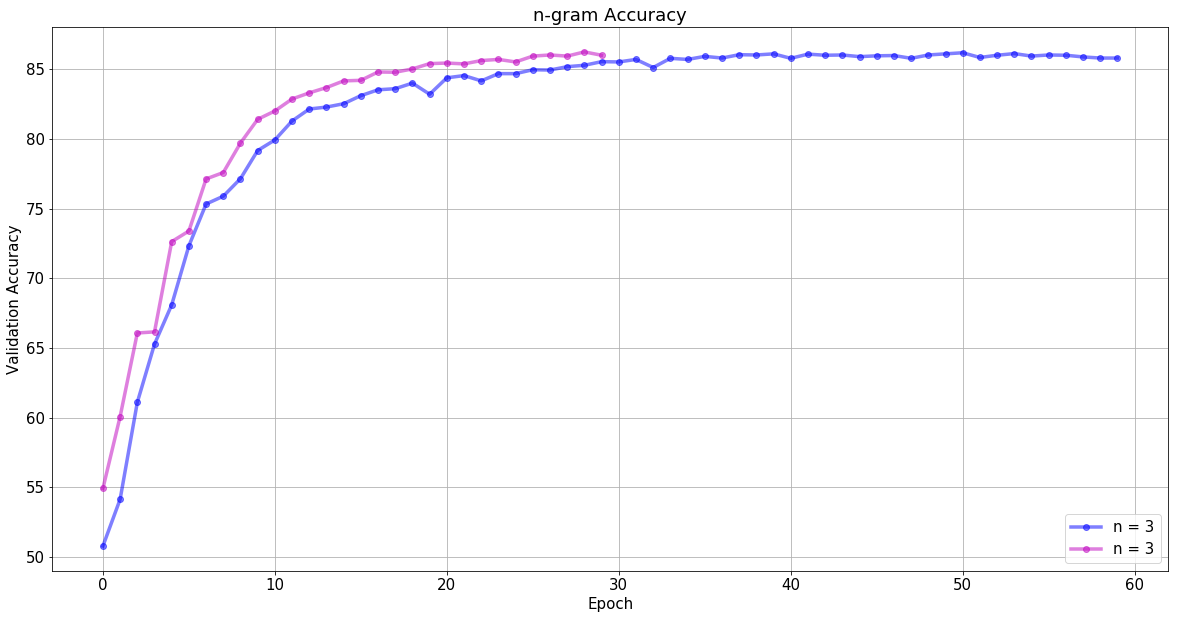

In [380]:
param_set_df_plot = hyperparams_plot[(hyperparams_plot["learning_rate"]==lr)&\
                          (hyperparams_plot["vocab_size"]==100000)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("n = " + str(param_set_df_plot["ngrams"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("n-gram Accuracy")

#### Learning Rate

In [391]:
ablation_params_lr = [[1,2,3], ## learning rates
          [25000,50000,100000], ## vocab size
          [100,200], ## embedding size
          [200], ## max sentence length
          ["SGD","Adam"] ##Optimizer
         ]

param_set = pd.Series([*(itertools.product(*ablation_params_lr))]).unique()[15]
n = param_set[0]
vocab = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
optimizer = param_set[4]

param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["vocab_size"]==vocab)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["optimizer"]==optimizer)]

# param_set_df[ablation_cols]

n= 2
vocab_size= 25000
embed_dim= 200
sentence_len= 200
optimizer=Adam


Text(0.5,1,'Learning Rate Accuracy')

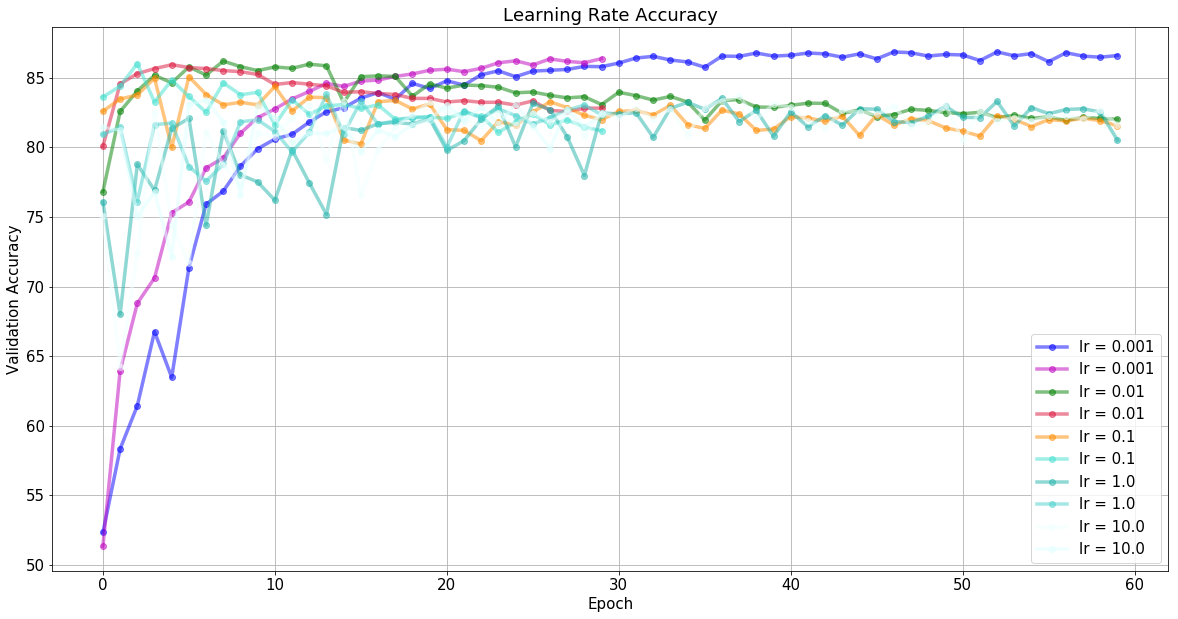

In [393]:
print ("n= "+str(n))
print ("vocab_size= "+str(vocab))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("optimizer=" + str(optimizer))

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["vocab_size"]==vocab)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("lr = " + str(param_set_df_plot["learning_rate"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Learning Rate Accuracy")

n= 3
vocab_size= 100000
embed_dim= 200
sentence_len= 200
optimizer=Adam


Text(0.5,1,'Learning Rate Accuracy')

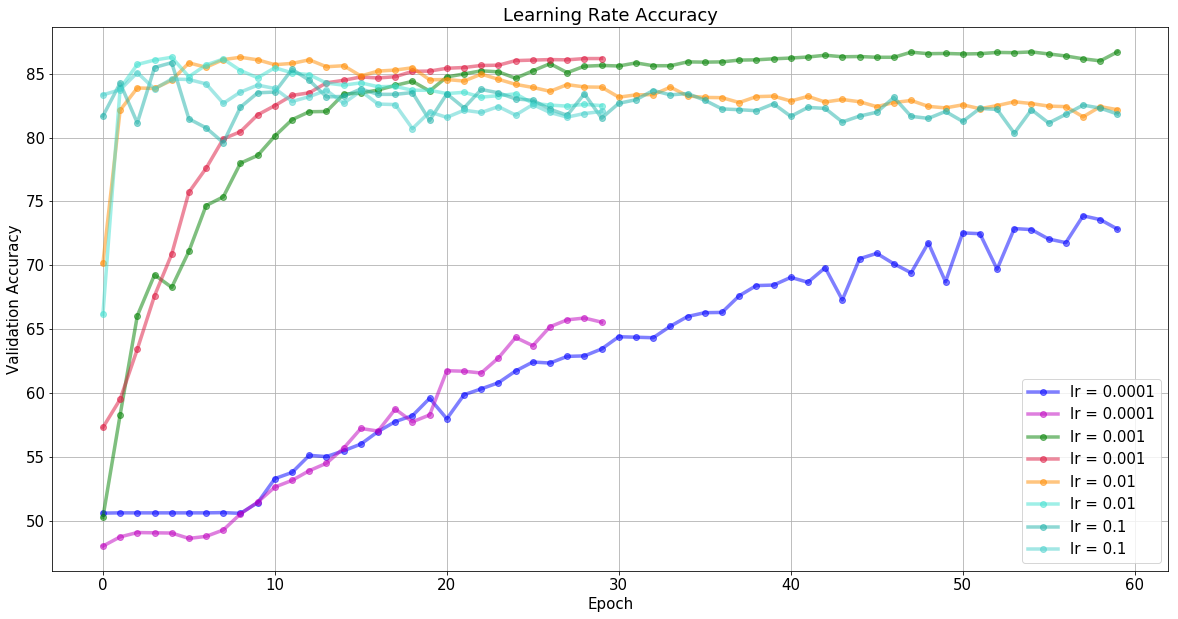

In [394]:
## CHANGE PARAM SET 
param_set = pd.Series([*(itertools.product(*ablation_params_lr))]).unique()[-1]
n = param_set[0]
vocab = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
optimizer = param_set[4]

print ("n= "+str(n))
print ("vocab_size= "+str(vocab))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("optimizer=" + str(optimizer))

## RENEW DF
param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["vocab_size"]==vocab)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["optimizer"]==optimizer)]

param_set_df[ablation_cols]

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["vocab_size"]==vocab)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("lr = " + str(param_set_df_plot["learning_rate"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Learning Rate Accuracy")

#### Vocab Size

In [465]:
ablation_params_vocab = [[1,2,3], ## ngrams
          [1e-3,1e-2,1e-1,1,10], ## learning rate
          [100,200], ## embedding size
          [200], ## max sentence length
          ["SGD","Adam"] ##Optimizer
         ]

param_set = pd.Series([*(itertools.product(*ablation_params_vocab))]).unique()[-13]
n = param_set[0]
lr = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
optimizer = param_set[4]

param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["learning_rate"]==lr)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["optimizer"]==optimizer)]

# param_set_df[ablation_cols]

In [466]:
# pd.Series([*(itertools.product(*ablation_params_vocab))]).unique()

n= 3
lr= 0.01
embed_dim= 200
sentence_len= 200
optimizer=Adam


Text(0.5,1,'Vocab Size Accuracy')

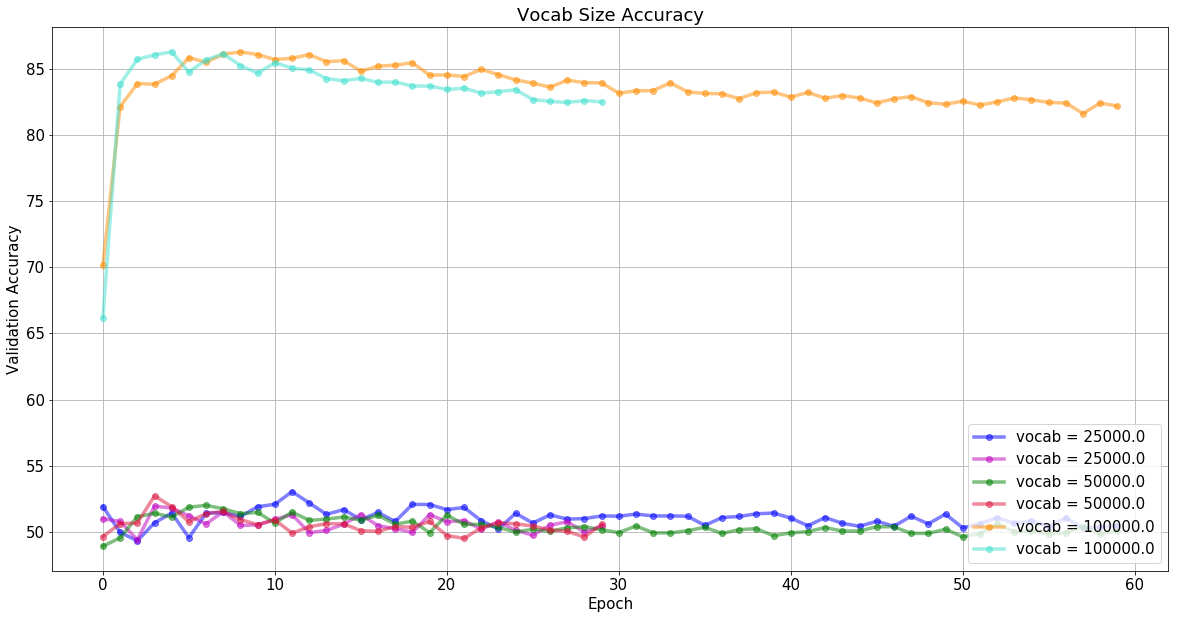

In [467]:
print ("n= "+str(n))
print ("lr= "+str(lr))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("optimizer=" + str(optimizer))

## RENEW DF

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["learning_rate"]==lr)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("vocab = " + str(param_set_df_plot["vocab_size"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Vocab Size Accuracy")

In [469]:
ablation_params_vocab = [[1,2,3], ## ngrams
          [1e-3,1e-2,1e-1,1,10], ## learning rate
          [100,200], ## embedding size
          [200], ## max sentence length
          ["SGD","Adam"] ##Optimizer
         ]

param_set = pd.Series([*(itertools.product(*ablation_params_vocab))]).unique()[1]
n = param_set[0]
lr = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
optimizer = param_set[4]

param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["learning_rate"]==lr)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["optimizer"]==optimizer)]

# param_set_df[ablation_cols]

n= 1
lr= 0.001
embed_dim= 100
sentence_len= 200
optimizer=Adam


Text(0.5,1,'Vocab Size Accuracy')

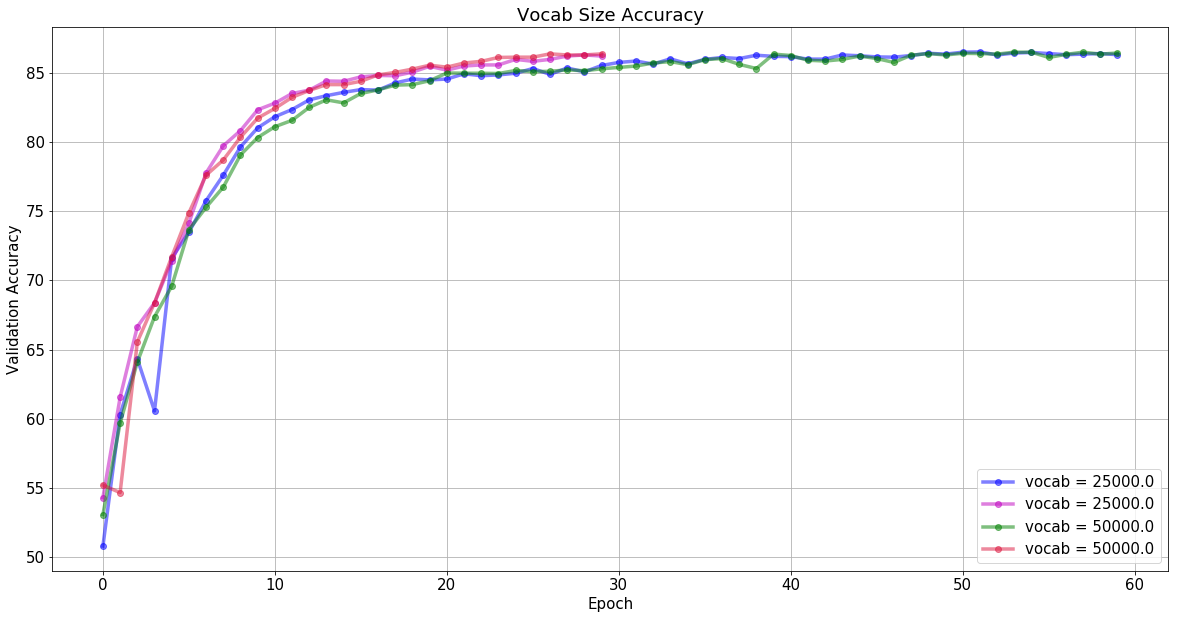

In [470]:
print ("n= "+str(n))
print ("lr= "+str(lr))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("optimizer=" + str(optimizer))

## RENEW DF

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["learning_rate"]==lr)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["optimizer"]==optimizer)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("vocab = " + str(param_set_df_plot["vocab_size"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Vocab Size Accuracy")

#### Optimizer

In [427]:
ablation_params_opt = [[1,2,3], ## ngrams
          [1e-3,1e-2,1e-1,1,10], ## learning rate
          [100,200], ## embedding size
          [200], ## max sentence length
          [25000,50000,100000]
         ]

param_set = pd.Series([*(itertools.product(*ablation_params_opt))]).unique()[1]
n = param_set[0]
lr = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
vocab_size = param_set[4]

param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["learning_rate"]==lr)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["vocab_size"]==vocab_size)]

# param_set_df[ablation_cols]

n= 1
lr= 0.001
embed_dim= 100
sentence_len= 200
vocab_size=50000


Text(0.5,1,'Optimizer Accuracy')

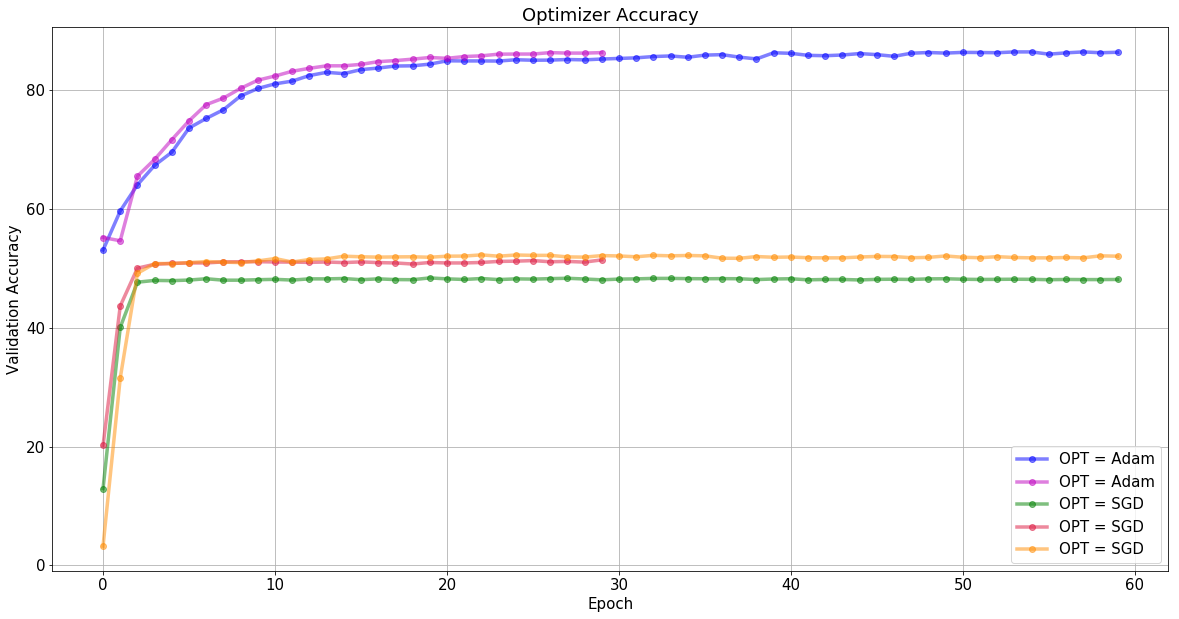

In [429]:
print ("n= "+str(n))
print ("lr= "+str(lr))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("vocab_size=" + str(vocab_size))

## RENEW DF

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["learning_rate"]==lr)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["vocab_size"]==vocab_size)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("OPT = " + str(param_set_df_plot["optimizer"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Optimizer Accuracy")

lr= 0.1
embed_dim= 200
sentence_len= 200
vocab_size=100000


Text(0.5,1,'Optimizer Accuracy')

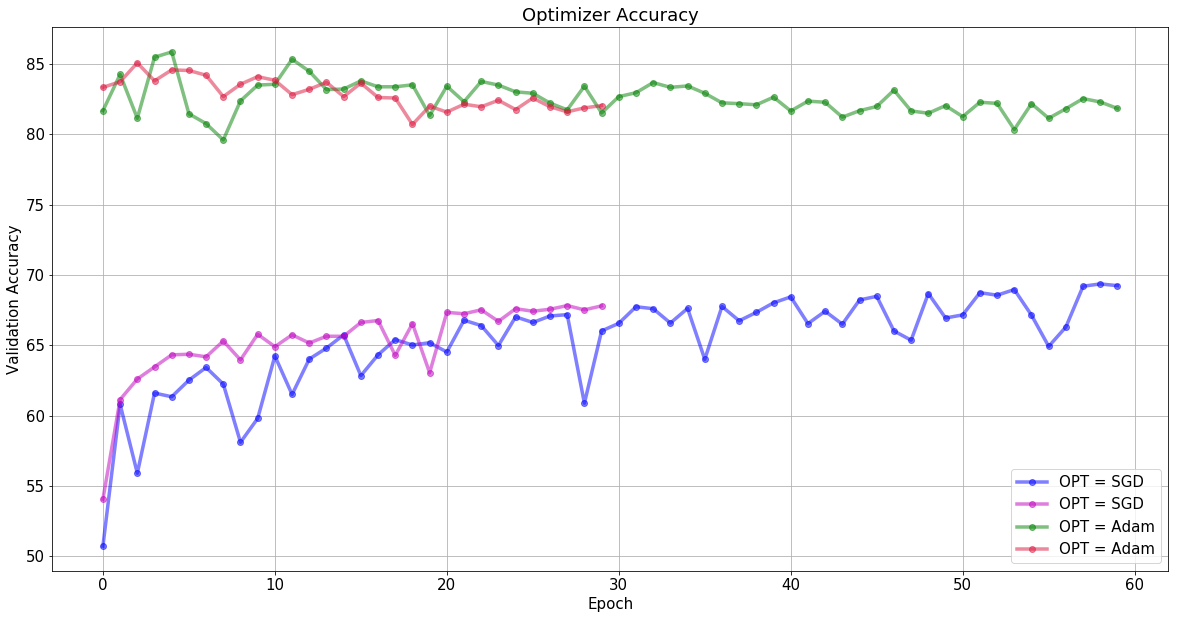

In [453]:
param_set = pd.Series([*(itertools.product(*ablation_params_opt))]).unique()[-13]
n = param_set[0]
lr = param_set[1]
embed_dim = param_set[2]
sentence_len = param_set[3]
vocab_size = param_set[4]

param_set_df = hyperparams[(hyperparams["ngrams"]==n)&\
                          (hyperparams["learning_rate"]==lr)&\
                           (hyperparams["embedding_size"]==embed_dim)&\
                          (hyperparams["vocab_size"]==vocab_size)]

# param_set_df[ablation_cols]print ("n= "+str(n))
print ("lr= "+str(lr))
print ("embed_dim= "+str(embed_dim))
print ("sentence_len= "+str(sentence_len))
print ("vocab_size=" + str(vocab_size))

## RENEW DF

param_set_df_plot = hyperparams_plot[(hyperparams_plot["ngrams"]==n)&\
                          (hyperparams_plot["learning_rate"]==lr)&\
                           (hyperparams_plot["embedding_size"]==embed_dim)&\
                          (hyperparams_plot["vocab_size"]==vocab_size)]

# param_set_df_plot

### START PLOT
plt.figure(figsize=(20,10))

val_accs = {}
for i in [*range(param_set_df_plot.shape[0])]:
    val_accs[i] = [float(x) for x in [*param_set_df_plot.iloc[i]["val_acc"]]]

for i in [*range(param_set_df_plot.shape[0])]:
    plt.plot(val_accs[i],
            linewidth=3.5,
            alpha=0.5,
            marker="o",
            color=colors[i],
            label=str("OPT = " + str(param_set_df_plot["optimizer"].iloc[i])))
    
plt.xticks()
plt.grid()
# plt.yticks(np.array(first_last).ravel())

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.rcParams["font.size"] = 15

## it's a huge legend, but nice to see
plt.legend(loc=4)

plt.title("Optimizer Accuracy")

### Test Performance

In [485]:
test_pos = read_review("data/aclImdb/test/pos/")
test_neg = read_review("data/aclImdb/test/pos/")

test_pos = [t+" 1" for t in test_pos]
test_neg = [t+" 0" for t in test_neg]

test_data = test_pos + test_neg

print ("Test dataset size is {}".format(len(test_data)))

test_data_labels = [int(x[-1]) for x in test_data]
test_data = [t[:-2] for t in test_data]

print ("Test labels size is {}".format(len(test_data_labels)))

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

##
## SELECTED TEST MODEL PARAMS
## 
step = 1e-3 ## learning rate
grams = 3 ## n-grams
vocab_size = 100000 ## vocab size
embed_dimension = 200 ## embedding size
max_sentence_length = 200 ## max sentence length of data loader
batch_size = 32
## optimizer assigned below - inside the model

param_losses = []

NUM_EPOCHS = 10

## LOSS CRITERION 
criterion = torch.nn.CrossEntropyLoss()

print ("Tokenizing training data.")
train_data_tokens, all_train_tokens = NGRAM_DATASETS[grams][0], NGRAM_DATASETS[grams][1]
print ("Tokenizing test data.")
test_data_tokens, _ = tokenize_dataset(test_data,n=grams)

print ("Building vocab")
## build vocab for the specified vocab size
token2id, id2token = build_vocab(all_train_tokens,
                                 size=vocab_size)

train_data_indices = token2index_dataset(train_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)
print ("Train and test indices ready.")

## assign max sentence length and batch size from 
## parameter space
MAX_SENTENCE_LENGTH = max_sentence_length
BATCH_SIZE = batch_size

train_dataset = NewsGroupDataset(train_data_indices, train_data_labels)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=imdb_func,
                                                   shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_data_labels)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=imdb_func,
                                           shuffle=True)

print ("Datasets ready.")

## model
model = BagOfNgrams(len(id2token), embed_dimension)

optimizers = [torch.optim.SGD(model.parameters(), lr=step)]
print ("Test Starting...")

for optimizer in optimizers:
    print ("Optimizer type: "+str(optimizer))
    for epoch in range(NUM_EPOCHS):
        for x, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # compute test score every 100 iterations
            if x > 0 and x % 100 == 0:
                # compute test score
                test_acc = test_model(test_loader, model)
                param_losses.append(test_acc)

Test dataset size is 25000
Test labels size is 25000
Tokenizing training data.
Tokenizing test data.
Building vocab
Train and test indices ready.
Datasets ready.
Test Starting...
Optimizer type: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [496]:
## forgot the optimizer as SGD, changing it to ADAM and running again 

NUM_EPOCHS = 5
## model
model = BagOfNgrams(len(id2token), embed_dimension)

optimizers = [torch.optim.Adam(model.parameters(), lr=step)]
print ("Test Starting...")
test_outs = []
for optimizer in optimizers:
    print ("Optimizer type: "+str(optimizer))
    for epoch in range(NUM_EPOCHS):
        print (epoch)
        for x, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            predicted = outputs.max(1, keepdim=True)[1]
            test_outs.append([predicted,label_batch])
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # compute test score every 100 iterations
            if x > 0 and x % 100 == 0:
                # compute test score
                test_acc = test_model(test_loader, model)
                param_losses.append(test_acc)

Test Starting...
Optimizer type: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
0
1
2
3
4


In [527]:
test_outs[4][0].numpy().ravel()

array([ 0,  3,  1,  0,  1, 16, 16, 14,  1,  0, 19, 11,  1,  1, 14,  1, 14,
        1,  0,  0,  1, 14,  0, 19,  0,  0,  0,  0,  1, 14, 14,  0])

In [548]:
## get the wrong pred indexes
test_accuracy = []
for i in test_outs[7:]:
    preds = i[0].numpy().ravel()
    true = i[1].numpy().ravel()
    percentage_score = np.sum(np.absolute(np.subtract(preds,true)))/len(preds)
    test_accuracy.append(percentage_score)
    
print ("Test accuracy is: "+str(1 - np.mean(test_accuracy)))

Test accuracy is: 0.8511165009621552


In [550]:
np.where(test_outs[-2][0].numpy().ravel()!=test_outs[-2][1].numpy().ravel())

(array([ 8, 23]),)

In [551]:
## correct preds
correct1 = [id2token[x] for x in test_data_indices[3]]
correct2 = [id2token[x] for x in test_data_indices[6]]
correct3 = [id2token[x] for x in test_data_indices[10]]
correct4 = [id2token[x] for x in test_data_indices[20]]
correct5 = [id2token[x] for x in test_data_indices[17]]

w1 = [id2token[x] for x in test_data_indices[1]]
w2 = [id2token[x] for x in test_data_indices[11]]
w3 = [id2token[x] for x in test_data_indices[18]]
w4 = [id2token[x] for x in test_data_indices[8]]
w5 = [id2token[x] for x in test_data_indices[23]]

In [532]:
(" ").join(correct1)

"i saw this film in a sneak preview and it is delightful the cinematography is unusually creative the acting is good and the story is fabulous if this movie does not do well it wo n't be because it does n't deserve to before this film i did n't realize how charming shia <unk> could be he does a marvelous self contained job as the lead there 's something incredibly sweet about him and it makes the movie even better the other actors do a good job as well and the film contains moments of really high suspense more than one might expect from a movie about golf sports movies are a dime a dozen but this one stands out br /><br />this is one i 'd recommend to anyone i saw saw this this film film in in a a sneak sneak preview <unk> and it it is is delightful <unk> the cinematography cinematography is <unk> <unk> <unk> the acting acting is is good good and and the the story story is is fabulous <unk> if this this movie movie does does not not do do well well it it wo wo n't n't be be because bec

In [533]:
(" ").join(correct2)

"maybe i 'm reading into this too much but i wonder how much of a hand <unk> had in developing the film i mean when a story is told casting the main character as himself i would think he would be a heavy hand in writing <unk> etc and that would make it a little <unk> /><br />but ... his family and friends also may have had a hand in getting the actual details about <unk> 's life i think the best view would have been told from <unk> 's family and friends perspectives they saw his transformation and were n't so messed up on drugs that they remember everything.<br /><br />as for <unk> being full of himself the <unk> of the jesus christ pose make him appear as a <unk> who sacrificed his life <unk> of course he 's obviously still alive as he was cast as himself for his family 's happiness <unk> /><br />the viewer sees him at his lowest points while still maintaining a superiority complex he lies on the grass coming down from during a high by himself and with his father he <unk> life and has

In [534]:
(" ").join(correct3)

"i loved this movie from beginning to end i am a musician and i let drugs get in the way of my some of the things i used to <unk> drawing but my friends were always there for me music was like my <unk> life support and my drug it changed my life i can totally relate to this movie and i wish there was more i could say this movie left me speechless to be honest i just saw it on the <unk> channel i usually hate having satellite but this was a <unk> of having satellite the <unk> channel shows some really great movies and without it i never would have found this movie <unk> not a big fan of the international films because i find that a lot of the do n't do a very good job on <unk> lines i mean the obvious language barrier leaves you to just believe that s what they are saying but its not that big of a deal i guess i almost never got to see this amazing movie good thing i stayed up for it instead of going to bed .. well earlier than <unk> hope you all enjoy the hell of this movie and love th

In [537]:
(" ").join(correct4)

"i have certainly not seen all of jean <unk> 's films but they mostly seem to be bloody vampire naked women <unk> which if you like that sort of thing is not bad but this is a major departure and could almost be cronenberg minus the bio mechanical nightmarish stuff except it 's in french with subtitles of course a man driving on the road at night comes across a woman that is in her <unk> and <unk> and picks her up while in the background yet another woman lingers wearing nothing as they drive along it 's obvious that there is something not right about the woman in that she forgets things almost as quickly as they happen still though that does n't prevent the man from having sex with her once they return to paris his apartment the man leaves for work and some strangers show up at his place and take the woman away to this tower block a huge apartment building referred to as the black tower where others of her kind for whom the no memory things seems to be the least of their problems are 

In [538]:
(" ").join(correct5)

"even if you 're a fan of jean <unk> 's idiosyncratic body of work you will be caught off guard by this exceptional <unk> into science fiction territory for once there 's not a single <unk> <unk> vampire girl in sight true to tradition the budget proved way too tight to realize the director 's vision entirely yet this is largely compensated by his obvious love of genre cinema dedication to his craft and sheer ingenuity jean claude <unk> 's atmospheric cinematography makes the most of the foreboding locations and philippe <unk> a k a gary <unk> contributes a startling soundtrack that fortunately does n't resemble any of the sappy stuff he composed for <unk> /><br <unk> in and around a paris office block before and after working hours the film was largely cast with porn regulars <unk> was already quite familiar with from his michel <unk> cash gathering <unk> efforts most notably french f*ck film royalty brigitte <unk> in the demanding lead playing elisabeth rather well i might add she 's

In [552]:
(" ").join(w1)

"actor turned director bill paxton follows up his promising debut the gothic horror frailty with this family friendly sports drama about the <unk> u.s. open where a young american <unk> rises from his humble background to play against his <unk> idol in what was dubbed as the greatest game ever played i 'm no fan of golf and these scrappy underdog sports flicks are a dime a dozen most recently done to grand effect with miracle and cinderella man but some how this film was enthralling all the same.<br /><br />the film starts with some creative opening credits imagine a <unk> version of the animated opening credits of hbo 's <unk> and rome but <unk> along slowly for its first by the numbers hour once the action moves to the u.s. open things pick up very well paxton does a nice job and shows a knack for effective directorial <unk> i loved the rain soaked montage of the action on day two of the open that propel the plot further or add some unexpected psychological depth to the proceedings t

In [553]:
(" ").join(w2)

"i was fortunate to attend the london premier of this film while i am not at all a fan of british drama i did find myself deeply moved by the characters and the bad choices they made i was in tears by the end of the film every scene was mesmerizing the attention to detail and the excellent acting was quite <unk> /><br />i would have to agree with some of the other comments here which question why all these women were throwing themselves at such a despicable character.<br /><br <unk> alert i was also hoping that dylan would have been killed by william when he had the chance end <unk> /><br <unk> knightley did a great job and <unk> beauty and innocence from the screen but it was <unk> miller 's performance that was truly oscar <unk> /><br />i am sure this production will be nominated for other awards i was <unk> <unk> to attend attend the the london <unk> <unk> of this this film film while while i i am am not not at at all all a a fan fan of of british <unk> drama i i did did find find m

In [554]:
(" ").join(w3)

"i was surprised how much i enjoyed this sure it is a bit slow moving in parts but what else would one expect from <unk> also there is plenty of nudity nothing wrong with that particularly as it includes lots of the gorgeous brigitte <unk> there are also some spectacularly <unk> female dead bit more <unk> perhaps but most effective there is also a sci fi like storyline with a brief explanation at the end but i would n't bother too much with that no here we have a most interesting exploration of memory and the effect of memory loss and to just what extent one is still alive without memory my dvd sleeve mentions david cronenberg and whilst this is perhaps not quite as good as his best films there is some similarity here particularly with the great use of seemingly menacing architecture and the effective and creepy use of inside space as i have tried to indicate this is by no means a rip roaring thriller it is a captivating nightmare like movie that makes the very most of its locations in

In [555]:
(" ").join(w4)

"this movie is amazing because the fact that the real people portray themselves and their real life experience and do such a good job it 's like they 're almost living the past over again <unk> <unk> plays himself an actor who quit everything except music and drugs struggling with depression and searching for the meaning of life while being angry at everyone especially the people who care for him most there 's moments in the movie that will make you wanna cry because the family especially the father did such a good job however this movie is not for everyone many people who suffer from depression will understand <unk> 's problem and why he does the things he does for example keep himself shut in a dark room or go for walks or bike rides by himself others might see the movie as boring because it 's just so real that its almost like a documentary overall this movie is great and <unk> deserved an oscar for this movie so did his dad this movie movie is is amazing <unk> because the the fact 

In [556]:
(" ").join(w5)

"felix in hollywood is a great film the version i viewed was very well restored which is sometimes a problem with these silent era animated films it has some of hollywood 's most famous stars making cameo animated appearances a must for any silent film or animation enthusiast <unk> in hollywood hollywood is is a a great great film film the the version version i i viewed <unk> was very very well <unk> <unk> which is is sometimes sometimes a a problem problem with with these <unk> silent era <unk> animated films films it it has has some some of of hollywood hollywood 's 's most most famous <unk> <unk> <unk> <unk> <unk> <unk> a must must for for any <unk> silent film film or <unk> <unk> <unk> <unk> <unk> is a great a great film great film the <unk> the version i <unk> <unk> <unk> was very well <unk> <unk> <unk> <unk> <unk> <unk> a problem with <unk> <unk> <unk> <unk> <unk> <unk> <unk> it has some has some of <unk> of hollywood 's <unk> 's most famous <unk> <unk> <unk> <unk> <unk> <unk> <u